In [2]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns 
from typing import List, Tuple, Dict, Any, Union
from openpyxl import load_workbook


In [3]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"


In [4]:
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":18})
rc("text", usetex=True)

In [5]:
MPLHEP = False
if MPLHEP:
    import mplhep as hep
    plt.style.use(hep.style.CMS)

In [6]:
sys.path.append("../../nuclearpy_models")
from models.BE import dz_be, semf_be
from models.BE import SRBEModels
from utils.metrics import RegressionMetrics

In [7]:
exp_df = pd.read_csv('../../Data/Experimental/AME2020.csv', delimiter=',').query("Z>=20").drop_duplicates(subset=['Z', 'N'])
exp_df["A"] = exp_df["Z"] + exp_df["N"]
# exp_df = exp_df.query("Z%2==0 and N%2==0")

## Inference

In [8]:
sr = SRBEModels(base_model="base")

In [9]:
exp_df["semf_pred"] = exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
exp_df["dz_pred"] = exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)
exp_df["sr_pred"] = (exp_df.apply(lambda x: sr(x["Z"], x["N"]), axis=1)) 
exp_df["sr_error"] = exp_df["sr_pred"] - exp_df["BE"]
exp_df["dz_error"] = exp_df["dz_pred"] - exp_df["BE"]


<Axes: xlabel='A', ylabel='sr_error'>

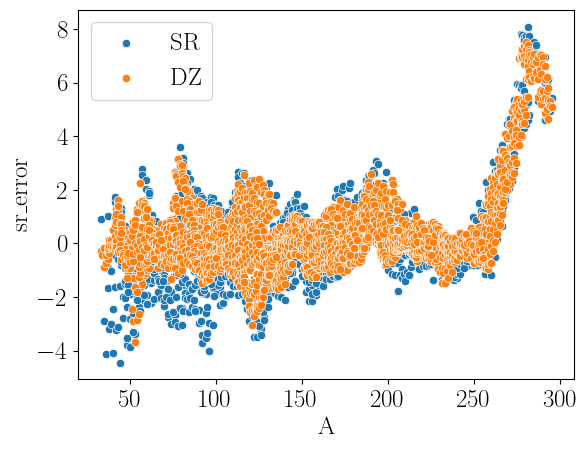

In [10]:
sns.scatterplot(data=exp_df, x="A", y="sr_error", label="SR")
sns.scatterplot(data=exp_df, x="A", y="dz_error", label="DZ")

#### Loading test

In [11]:
PATH_THEORY = "../../Data/Theory/MasterNuclei.xlsx"
def get_sheets_name(filename):
    workbook = load_workbook(filename)
    return workbook.sheetnames


used_dfs = [
    "DD-ME2",
    #"SKMS",
    "UNEDF0",
    "HFB24"
]

th_datastes = get_sheets_name(PATH_THEORY)
th_datastes = [th_dataste for th_dataste in used_dfs if th_dataste != "AME2020"]

In [12]:
th_datastes

['DD-ME2', 'UNEDF0', 'HFB24']

In [13]:
thdfs = {th_dataste: pd.read_excel(PATH_THEORY, sheet_name=th_dataste) for th_dataste in th_datastes}

In [14]:
def get_th_pred(Z, N, df_th):
    try:
        return df_th[(df_th["Z"] == Z) & (df_th["N"] == N)]["BE"].values[0]
    except:
        return np.nan

def patient_semf(Z, N):
    try:
        return dz_be(Z, N)
    except Exception as e:
        return np.nan

all_th_dfs = {}
all_th_in_exp = {}
for df_name in used_dfs:
    foo = thdfs.get(df_name).copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr(x["Z"], x["N"]), axis=1)
    all_th_dfs[df_name] = foo.dropna()
    foo = exp_df.copy()
    foo["th_pred"] = foo.apply(lambda x: get_th_pred(x["Z"], x["N"], thdfs[df_name]), axis=1)
    foo["dz_pred"] = foo.apply(lambda x: patient_semf(x["Z"], x["N"]), axis=1)
    foo["dz_diff"] = foo.apply(lambda x: x["dz_pred"] - x["th_pred"], axis=1)
    foo["sr"] = foo.apply(lambda x: sr(x["Z"], x["N"]), axis=1)
    all_th_in_exp[df_name] = foo.dropna()


Z=92.0, N=206.0 not found in precomputed data
Z=92.0, N=208.0 not found in precomputed data
Z=92.0, N=210.0 not found in precomputed data
Z=94.0, N=204.0 not found in precomputed data
Z=94.0, N=206.0 not found in precomputed data
Z=94.0, N=208.0 not found in precomputed data
Z=94.0, N=210.0 not found in precomputed data
Z=94.0, N=212.0 not found in precomputed data
Z=94.0, N=214.0 not found in precomputed data
Z=96.0, N=202.0 not found in precomputed data
Z=96.0, N=204.0 not found in precomputed data
Z=96.0, N=206.0 not found in precomputed data
Z=96.0, N=208.0 not found in precomputed data
Z=96.0, N=210.0 not found in precomputed data
Z=96.0, N=212.0 not found in precomputed data
Z=96.0, N=214.0 not found in precomputed data
Z=96.0, N=216.0 not found in precomputed data
Z=96.0, N=218.0 not found in precomputed data
Z=98.0, N=200.0 not found in precomputed data
Z=98.0, N=202.0 not found in precomputed data
Z=98.0, N=204.0 not found in precomputed data
Z=98.0, N=206.0 not found in preco

# Regression Metrics

In [15]:
exp_df

,BE,uBE,N,Z,eBE,A,semf_pred,dz_pred,sr_pred,sr_error,dz_error
363,219.681000,0.396000,13,20,1,33,214.087717,219.40154,220.573727,0.892727,-0.279460
364,243.882000,0.306000,14,20,1,34,238.882453,243.44692,243.446920,-0.435080,-0.435080
365,261.660000,0.210000,15,20,1,35,257.675433,260.77830,261.228087,-0.431913,-0.881700
366,281.371676,0.040000,16,20,0,36,278.798855,280.64268,280.642680,-0.728996,-0.728996
367,296.127898,0.000633,17,20,0,37,294.335851,295.54506,295.221227,-0.906671,-0.582838
...,...,...,...,...,...,...,...,...,...,...,...
3551,2078.835000,0.879000,176,117,1,293,2087.489644,2084.17339,2083.897706,5.062706,5.338390
3552,2085.048000,0.588000,177,117,1,294,2093.957097,2090.34177,2089.990538,4.942538,5.293770
3553,2073.854000,0.586000,175,118,1,293,2080.704578,2078.48704,2078.853748,4.999748,4.633040
3554,2081.226000,0.588000,176,118,1,294,2088.853456,2086.33242,2086.332420,5.106420,5.106420


In [16]:
semf_metrics = RegressionMetrics(exp_df["BE"], exp_df["semf_pred"], "SEMF")()
dz_metrics = RegressionMetrics(exp_df["BE"], exp_df["dz_pred"], "DZ")()
dz_sr_metrics = RegressionMetrics(exp_df["BE"], exp_df["sr_pred"], "sr")()
results = pd.concat([semf_metrics, dz_metrics, dz_sr_metrics], axis=0)

#for df_name in used_dfs:
#    res = (RegressionMetrics(all_th_in_exp[df_name]["BE"], all_th_in_exp[df_name]["th_pred"], df_name)())
#    results = pd.concat([results, res], axis=0)
#all_th_dfs: Dict[str, pd.DataFrame]

results[["RMSE"]].sort_values(by="RMSE", inplace=False).rename(columns={"RMSE": "RMSE [MeV]"})

,RMSE [MeV]
DZ,1.330063
sr,1.468211
SEMF,4.499549


#

In [17]:
def plot_isotope_be(
    df: pd.DataFrame,
    models: List[callable] = [dz_be, dz_be],
    model_names: List[str] = ["DZ", "SR"],
    fixed_z: int = 50,
    n_max = 120,
    ):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    # Select values
    foo_df = df.query(f"Z=={fixed_z}")#.query(f"(Z % 2) == 0").query(f"(N % 2) == 0")
    # get values
    n_min = foo_df["N"].min()
    ns_in = foo_df["N"].values
    ns_out = np.arange(ns_in.max(), n_max)
    all_ns = np.concatenate([ns_in, ns_out])
    # Predictions for DZ models
    y = np.array([dz_be(fixed_z, n) for n in all_ns])
    # Plot
    # Horizontal line for dz_be values
    ax.plot(foo_df["N"], foo_df["BE"]*0, label="DZ-10", color="black", alpha=0.5)
    ax.hlines(0, n_min, n_max, color="black", linestyle="-")
    
    # scatter experimental values
    SEMF_error = foo_df["dz_pred"] - foo_df["BE"] 
    sns.scatterplot(x="N", y=SEMF_error, data=foo_df, ax=ax, label="Experiment", color="black")
    # Put a vertical line on the last experimental value
    ax.vlines(foo_df["N"].max(), -10, 10, color="black", linestyle="--", alpha=0.3)
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Predictions for ns_in
        preds_in = np.array([model(fixed_z, n) for n in all_ns])
        errors = y - preds_in
        sns.scatterplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", s=5)
        sns.lineplot(x=all_ns, y=errors, ax=ax, color=f"C{i}", linestyle=":", label=name)
        
    # Theoretical predictions
    for j, df_name in enumerate(used_dfs):
        sns.scatterplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, s=10, color=f"C{j+2+i}")
        sns.lineplot(x="N", y="dz_diff", data=all_th_dfs[df_name].query(f"Z=={fixed_z}"), ax=ax, linestyle="--", label=df_name,  color=f"C{j+2+i}")
    
    ax.set(xlabel="N", ylabel=r"$\delta(B_E)$ [MeV]", title=f"$Z = {fixed_z}$ ", xlim=(n_min, n_max), ylim=(-10, 10))
    # create an anotation inside the plot)
    # Reduce the size of the legend
    ax.legend(fontsize=14)

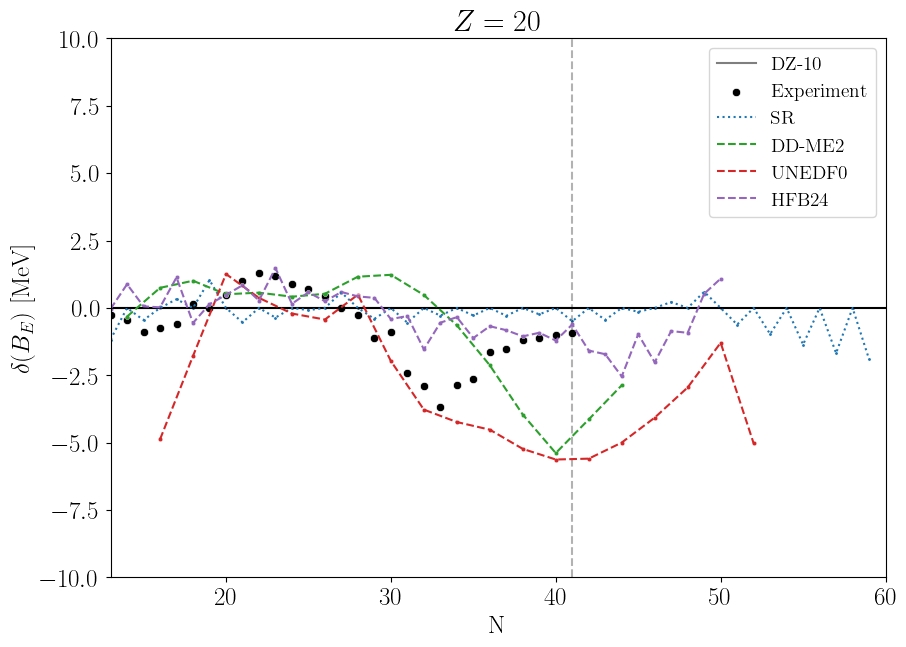

In [18]:
plot_isotope_be(exp_df, models=[sr],
                model_names = ["SR"],
                fixed_z=20, n_max=60)

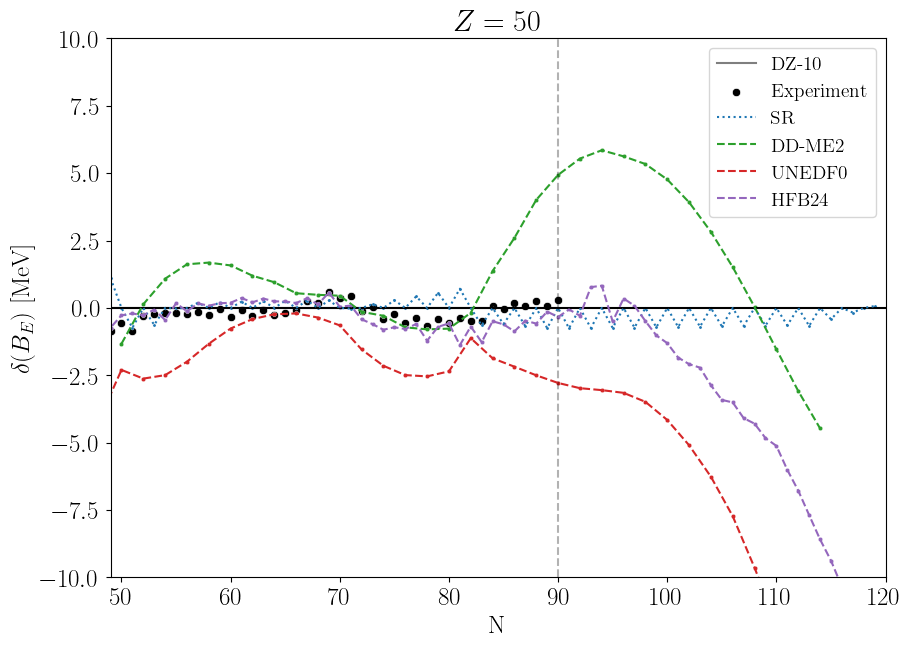

In [19]:
plot_isotope_be(exp_df, models=[sr],
                model_names = ["SR", "SR(SEMF)"],
                fixed_z=50, n_max=120)

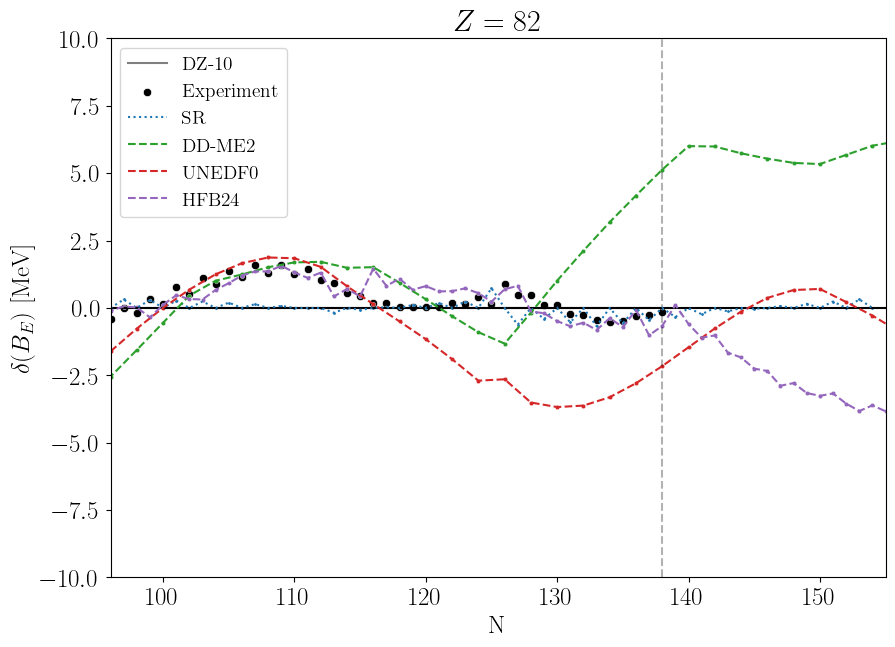

In [20]:
plot_isotope_be(exp_df, models=[sr],
                model_names = ["SR", "SR(SEMF)"],
                fixed_z=82, n_max=155)

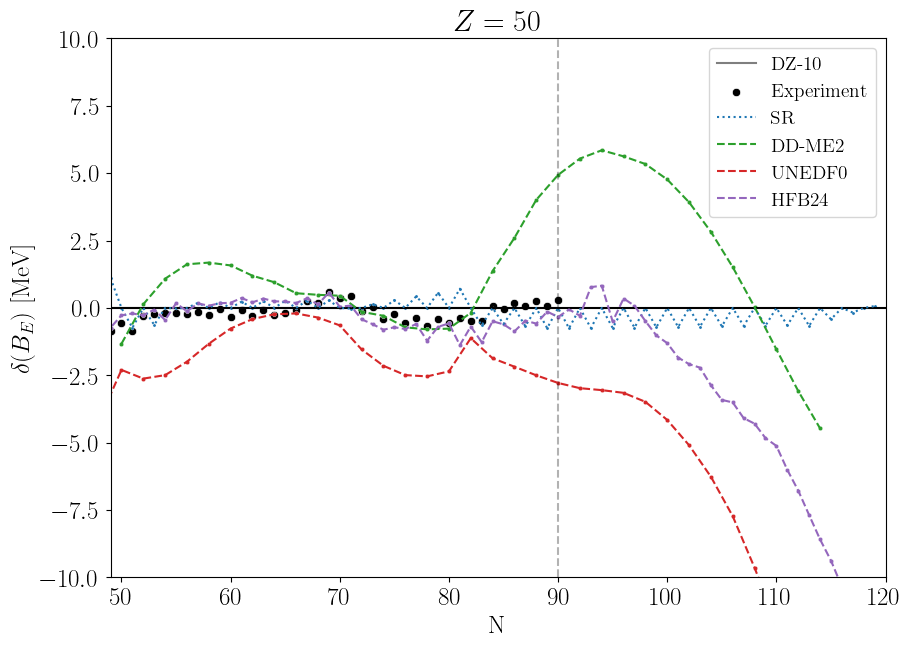

In [21]:
plot_isotope_be(exp_df, models=[sr],
                model_names = ["SR"],
                fixed_z=50, n_max=120)

# Unseen data

In [22]:

full_exp_df = pd.read_excel("../../Data/Theory/MasterNuclei.xlsx", sheet_name="AME2020")


In [23]:
%%capture
full_exp_df["sr_pred"] = full_exp_df.apply(lambda x: sr(x["Z"], x["N"]), axis=1)
full_exp_df["SEMF"] = full_exp_df.apply(lambda x: semf_be(x["Z"], x["N"]), axis=1)
full_exp_df["dz_pred"] = full_exp_df.apply(lambda x: dz_be(x["Z"], x["N"]), axis=1)

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_65782/1538528229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foo_19["sr_pred"] = foo_19.apply(lambda x: sr(x["Z"], x["N"]), axis=1)


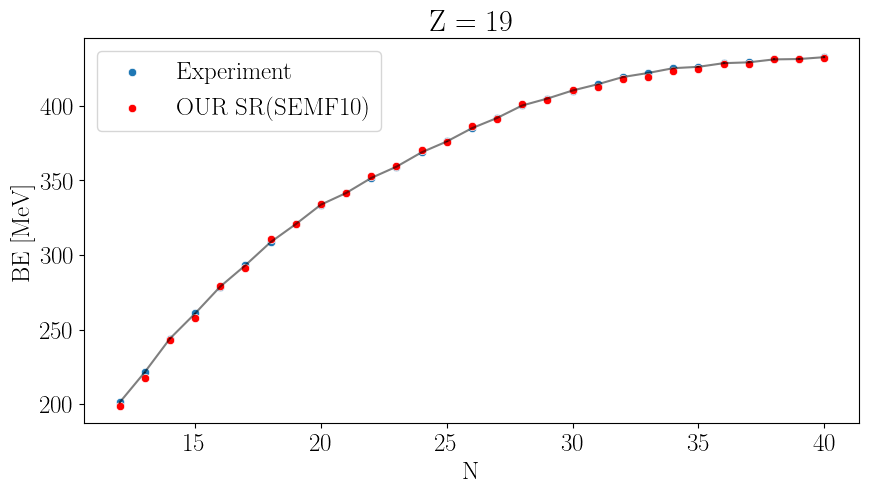

In [24]:
foo_19 = full_exp_df.query("Z==19")
foo_19["sr_pred"] = foo_19.apply(lambda x: sr(x["Z"], x["N"]), axis=1)
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x="N", y="BE", data=foo_19, label="Experiment")
# Uncertainty uBE
plt.errorbar(foo_19["N"], foo_19["BE"], yerr=foo_19["uBE"], color="black", alpha=0.5)
sns.scatterplot(x="N", y="sr_pred", data=foo_19, label="OUR SR(SEMF10)", color="red")
ax.set_xlabel("N")
ax.set_ylabel("BE [MeV]")
ax.set_title("Z = 19")
plt.show()

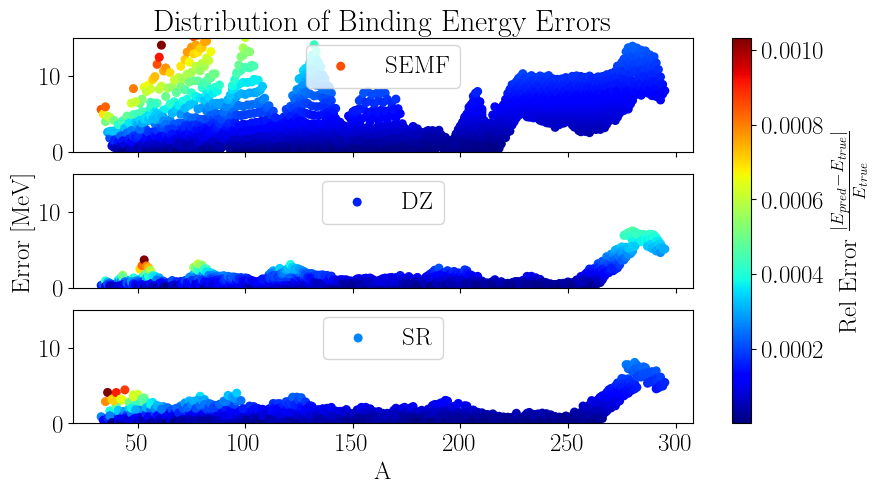

In [25]:
foo_full = full_exp_df.copy().query("Z>=20")
regr_error = np.abs((foo_full.sr_pred - foo_full.BE.values))
SEMF_error = np.abs((foo_full.SEMF - foo_full.BE.values))
dz_error = np.abs((foo_full.dz_pred - foo_full.BE.values))
max_error = np.max([regr_error, SEMF_error, dz_error])

A = foo_full["Z"] + foo_full["N"]
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i, (data, label) in enumerate(
    zip([SEMF_error, dz_error, regr_error], ["SEMF", "DZ", "SR"])
):
    rel_error = np.abs(data / foo_full.BE.values)
    g = ax[i].scatter(A, data, c=rel_error / max_error, cmap="jet", s=30, label=label)
    # set location of legend
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))
    ax[i].set(ylim=(0, 15))
ax[i].set_xlabel("A")
ax[1].set_ylabel("Error [MeV]", rotation=90)

ax[0].set_title("Distribution of Binding Energy Errors")
# Add a colorbar to the figure
ax[0].figure.colorbar(g, ax=ax, label = r"Rel Error $\frac{|E_{pred} - E_{true}|}{E_{true}}$")

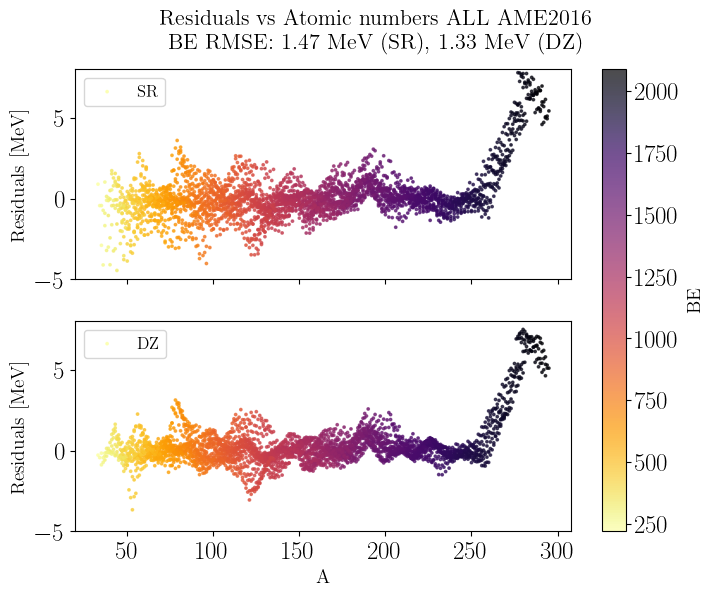

In [33]:
import numpy as np
import matplotlib.pyplot as plt
foo_df = foo_full#.query('is_spherical==0')
foo_df["A"] = foo_df["Z"] + foo_df["N"]
# Remove the values of foo_df where the rc is np.nan
# foo_df = foo_df[~foo_df['rc'].isna()]

be_train_preds = foo_df.apply(lambda x: sr(x['Z'], x['N']), axis=1)
semf_train_preds = foo_df.apply(lambda x: semf_be(x['Z'], x['N']), axis=1)
dz_train_preds = foo_df.apply(lambda x: dz_be(x['Z'], x['N']), axis=1)
# Define a function to calculate the RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Calculate the RMSE for the training set
be_train_rmse = rmse(foo_df['BE'], be_train_preds)
dz_train_rmse = rmse(foo_df['BE'], dz_train_preds)

# Plot both residuals [MeV] against A, colored by BE
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].scatter(foo_df['A'], be_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='inferno_r', label='SR', alpha=0.7, s=3)
ax[1].scatter(foo_df['A'], dz_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='inferno_r', label='DZ', alpha=0.7, s=3)

# Add axis labels and a title
ax[1].set_xlabel('A', fontsize=14)
ax[0].set_ylabel('Residuals [MeV]', fontsize=14)
ax[1].set_ylabel('Residuals [MeV]', fontsize=14)
fig.suptitle('Residuals vs Atomic numbers ALL AME2016\nBE RMSE: {:.2f} MeV (SR), {:.2f} MeV (DZ)'.format(be_train_rmse, dz_train_rmse), fontsize=16)

# Add a colorbar and a legend
cbar = fig.colorbar(ax[0].collections[0], ax=ax) 
cbar.ax.set_ylabel('BE', fontsize=14)
ax[0].set_ylim(-5, 8)
ax[1].set_ylim(-5, 8)
ax[0].legend(loc='upper left', fontsize=12)
ax[1].legend(loc='upper left', fontsize=12)

# Save the figure

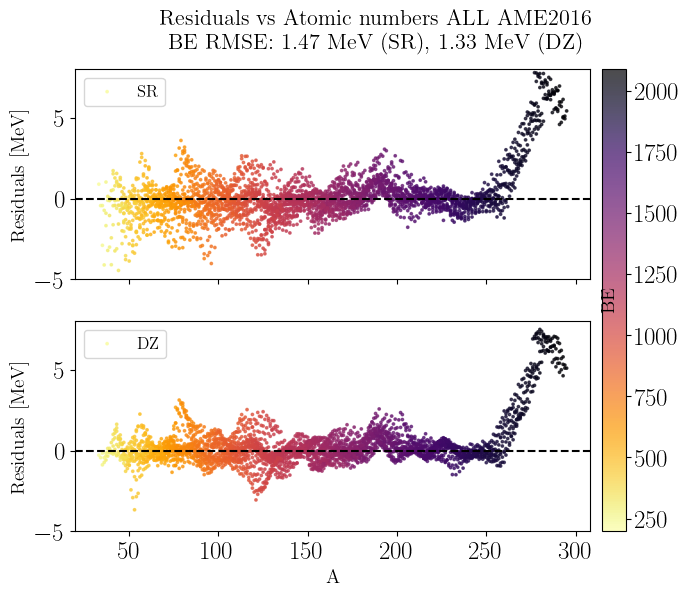

In [34]:
import numpy as np
import matplotlib.pyplot as plt
foo_df = foo_full#.query('is_spherical==0')
foo_df["A"] = foo_df["Z"] + foo_df["N"]
# Remove the values of foo_df where the rc is np.nan
# foo_df = foo_df[~foo_df['rc'].isna()]

be_train_preds = foo_df.apply(lambda x: sr(x['Z'], x['N']), axis=1)
semf_train_preds = foo_df.apply(lambda x: semf_be(x['Z'], x['N']), axis=1)
dz_train_preds = foo_df.apply(lambda x: dz_be(x['Z'], x['N']), axis=1)
# Define a function to calculate the RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Calculate the RMSE for the training set
be_train_rmse = rmse(foo_df['BE'], be_train_preds)
dz_train_rmse = rmse(foo_df['BE'], dz_train_preds)

# Plot both residuals [MeV] against A, colored by BE
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax[0].scatter(foo_df['A'], be_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='inferno_r', label='SR', alpha=0.7, s=3, vmin=0.9*np.min(foo_df['BE']))
ax[1].scatter(foo_df['A'], dz_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='inferno_r', label='DZ', alpha=0.7, s=3, vmin=0.9*np.min(foo_df['BE']))

# Add axis labels and a title
ax[1].set_xlabel('A', fontsize=14)
ax[0].set_ylabel('Residuals [MeV]', fontsize=14)
ax[1].set_ylabel('Residuals [MeV]', fontsize=14)
fig.suptitle('Residuals vs Atomic numbers ALL AME2016\nBE RMSE: {:.2f} MeV (SR), {:.2f} MeV (DZ)'.format(be_train_rmse, dz_train_rmse), fontsize=16)

# Add a colorbar and a legend
cbar = fig.colorbar(ax[0].collections[0], ax=ax, pad=0.02) 
cbar.ax.set_ylabel('BE', fontsize=14)
cbar.ax.yaxis.set_label_coords(-0.1, 0.5)
ax[0].set_ylim(-5, 8)
ax[1].set_ylim(-5, 8)
ax[0].legend(loc='upper left', fontsize=12)
ax[1].legend(loc='upper left', fontsize=12)

# Add a 0 line reference
ax[0].axhline(y=0, color='black', linestyle='--')
ax[1].axhline(y=0, color='black', linestyle='--')

# Save the figure

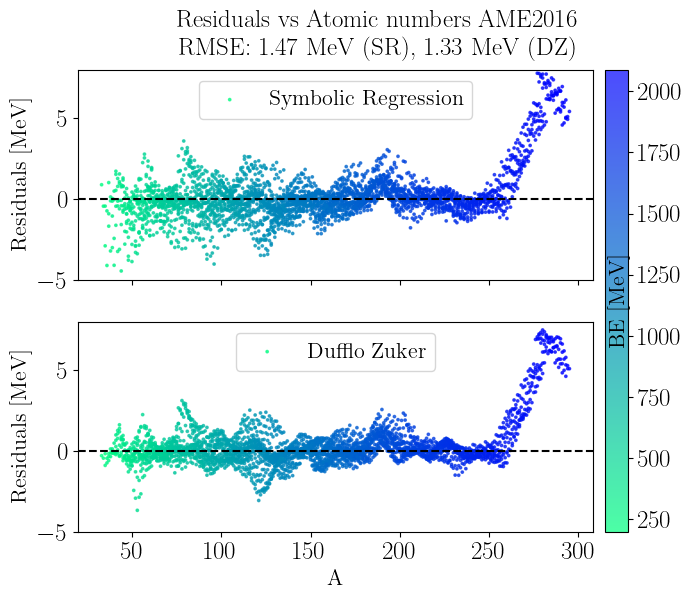

In [48]:
import numpy as np
import matplotlib.pyplot as plt
foo_df = foo_full#.query('is_spherical==0')
foo_df["A"] = foo_df["Z"] + foo_df["N"]
# Remove the values of foo_df where the rc is np.nan
# foo_df = foo_df[~foo_df['rc'].isna()]

be_train_preds = foo_df.apply(lambda x: sr(x['Z'], x['N']), axis=1)
semf_train_preds = foo_df.apply(lambda x: semf_be(x['Z'], x['N']), axis=1)
dz_train_preds = foo_df.apply(lambda x: dz_be(x['Z'], x['N']), axis=1)
# Define a function to calculate the RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Calculate the RMSE for the training set
be_train_rmse = rmse(foo_df['BE'], be_train_preds)
dz_train_rmse = rmse(foo_df['BE'], dz_train_preds)

# Plot both residuals [MeV] against A, colored by BE
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
ax[0].scatter(foo_df['A'], be_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='winter_r', label="Symbolic Regression", alpha=0.7, s=3, vmin=0.9*np.min(foo_df['BE']))
ax[1].scatter(foo_df['A'], dz_train_preds - foo_df['BE'], c=foo_df['BE'], cmap='winter_r', label="Dufflo Zuker", alpha=0.7, s=3, vmin=0.9*np.min(foo_df['BE']))
# Add axis labels and a title
ax[1].set_xlabel('A', fontsize=16)
ax[0].set_ylabel('Residuals [MeV]', fontsize=16)
ax[1].set_ylabel('Residuals [MeV]', fontsize=16)
fig.suptitle('Residuals vs Atomic numbers AME2016\n RMSE: {:.2f} MeV (SR), {:.2f} MeV (DZ)'.format(be_train_rmse, dz_train_rmse), fontsize=18)

# Add a colorbar and a legend
cbar = fig.colorbar(ax[0].collections[0], ax=ax, pad=0.02) 
cbar.ax.set_ylabel('BE [MeV]', fontsize=16)
cbar.ax.yaxis.set_label_coords(0.1, 0.5)
ax[0].set_ylim(-5, 8)
ax[1].set_ylim(-5, 8)
ax[0].legend(loc='upper center', fontsize=16)
ax[1].legend(loc='upper center', fontsize=16)

# Add a 0 line reference
ax[0].axhline(y=0, color='black', linestyle='--')
ax[1].axhline(y=0, color='black', linestyle='--')

# Save the figure